### Import Packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
# from citipy import citipy
import requests
import json
from api_keys import weather_api_key
from api_keys import g_key
import numpy as np
from scipy import stats as stats
import random
from pprint import pprint

In [2]:
from citipy import citipy

## Part I - WeatherPy

#### Getting 500 or more random cities

In [3]:
# set seed
np.random.seed(45)

# Create 1500 random latitude and longtitutde values
# some coordinates might be similar so when using citipy to find the nearest city,
# some cities might be duplicated so we create extra coordinates just in case

lat = np.random.uniform(-90,90,1600)
long = np.random.uniform(-180,180,1600)


In [4]:
# create a dataframe for the coordinates
city_info = pd.DataFrame({'lat':lat,'long':long})

In [5]:
# store city names of the closest city to the coordinates

city_name = []
country_code = []
for row in range(len(city_info)):
    lat_cord = city_info.iloc[row][0]
    long_cord = city_info.iloc[row][1]
    city = citipy.nearest_city(lat_cord,long_cord)
    city_name.append(city.city_name)
    country_code.append(city.country_code)
    

In [6]:
# add closest city and country codes to data frame
city_info['closest city'] = city_name
city_info['country code'] = country_code
city_info

,lat,long,closest city,country code
0,88.022072,-175.179778,mys shmidta,ru
1,8.918051,84.955594,batticaloa,lk
2,-39.339486,26.073336,port elizabeth,za
3,-76.087878,157.534549,bluff,nz
4,-9.995491,-171.446738,saleaula,ws
...,...,...,...,...
1595,-13.173362,165.342630,sola,vu
1596,-38.308041,165.248190,westport,nz
1597,-24.947645,-156.211283,avarua,ck
1598,-87.001050,-135.655265,rikitea,pf


In [7]:
# remove the duplicate cities (if any)
city_info = city_info.drop_duplicates('closest city')

# check how many unique cities we have
print(f' We have {city_info.shape[0]} unique cities')


 We have 645 unique cities


#### Using openweather API to to retrieve Temperature, Humidity, Cloudiness, Wind Speed

In [8]:
# store everything needed for the url to read the api
# url need when searching by geographical co ordinates
coord_url = "http://api.openweathermap.org/data/2.5/weather?"
units = "&units=imperial"
weather_api_key = "&appid="+weather_api_key

In [9]:
# create extra columns in city_info
temp = []
humidity = []
cloudiness = []
wind_speed = []

In [10]:
lat = 'lat='+str(city_info['lat'][0])
long = '&lon='+str(city_info['long'][0])

# create the url
new_url = coord_url+lat+long+weather_api_key+units
    
data =requests.get(new_url).json()


In [11]:
# create empty columns 
city_info['temp'] = " "
city_info['humidity'] = " "
city_info['cloudiness'] = " "
city_info['wind speed'] = " "
city_info

/var/folders/fb/n2345hrx7yb3xtc12f0ykjzr0000gn/T/ipykernel_60309/118569470.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city_info['temp'] = " "
/var/folders/fb/n2345hrx7yb3xtc12f0ykjzr0000gn/T/ipykernel_60309/118569470.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city_info['humidity'] = " "
/var/folders/fb/n2345hrx7yb3xtc12f0ykjzr0000gn/T/ipykernel_60309/118569470.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

,lat,long,closest city,country code,temp,humidity,cloudiness,wind speed
0,88.022072,-175.179778,mys shmidta,ru,,,,
1,8.918051,84.955594,batticaloa,lk,,,,
2,-39.339486,26.073336,port elizabeth,za,,,,
3,-76.087878,157.534549,bluff,nz,,,,
4,-9.995491,-171.446738,saleaula,ws,,,,
...,...,...,...,...,...,...,...,...
1580,-0.308852,167.515575,tabiauea,ki,,,,
1584,-22.138052,-65.847254,villazon,bo,,,,
1586,43.686514,-81.089327,listowel,ca,,,,
1589,-18.603939,-48.129096,araguari,br,,,,


In [12]:
print('starting search... (this may take a while)')
# keeps count of the city
count = 1

base = "https://api.openweathermap.org/data/2.5/weather?q="

for index,row in city_info.iterrows():
    
    # store lat and long values
    city = row['closest city']
    long = '&lon='+str(row['long'])
    lat = 'lat='+str(row['lat'])
    
    # create the url
    new_url = base+city+weather_api_key+units
    # read the data of the city from the API
    data =requests.get(new_url).json()
    
    # print log of city and which number it is
    print(f"Retreiving data for {city.title()}, this is city number: {count}.")
    count+= 1

    try:
        city_info.loc[index,"temp"]  = data["main"]["temp"]
        city_info.loc[index,"humidity"]  = data["main"]["humidity"]
        city_info.loc[index,"cloudiness"] = data['clouds']['all']
        city_info.loc[index,"wind speed"] = data['wind']['speed']
    except (KeyError, IndexError):
        city_info = city_info.drop(index)
        print(f"Can't find information for {city}... skipping.") 
        
    
print('search done')

starting search... (this may take a while)
Retreiving data for Mys Shmidta, this is city number: 1.
Can't find information for mys shmidta... skipping.
Retreiving data for Batticaloa, this is city number: 2.
Retreiving data for Port Elizabeth, this is city number: 3.
Retreiving data for Bluff, this is city number: 4.
Retreiving data for Saleaula, this is city number: 5.
Can't find information for saleaula... skipping.
Retreiving data for Omboue, this is city number: 6.
Retreiving data for Bredasdorp, this is city number: 7.
Retreiving data for Taolanaro, this is city number: 8.
Can't find information for taolanaro... skipping.
Retreiving data for Saint-Philippe, this is city number: 9.
Retreiving data for Marti, this is city number: 10.
Retreiving data for Tasiilaq, this is city number: 11.
Retreiving data for Lompoc, this is city number: 12.
Retreiving data for Qaanaaq, this is city number: 13.
Retreiving data for Takoradi, this is city number: 14.
Retreiving data for Sur, this is cit

In [33]:
city_info.shape

(594, 8)

In [35]:
# save data to csv
city_info.to_csv("retrieved_data.csv",index=False)

### Plot Lat

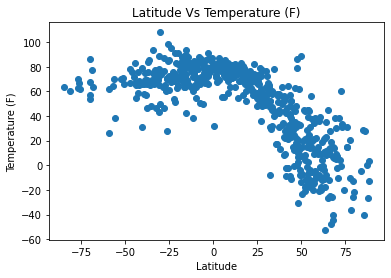

In [36]:
plt.scatter(city_info['lat'],city_info['temp'])
plt.xlabel('Latitude')
plt.ylabel('Temperature (F)')
plt.title('Latitude Vs Temperature (F)')
plt.show()

Here we plot the latitude values against the temperature in Farenheit. This shows us the how the temperature changes depending on the latitude value.

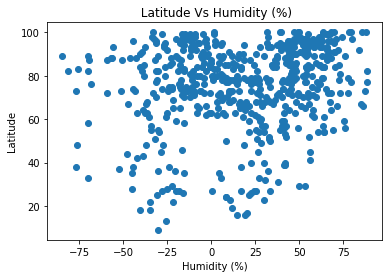

In [37]:
plt.scatter(city_info['lat'],city_info['humidity'])
plt.xlabel('Humidity (%)')
plt.ylabel('Latitude')
plt.title(' Latitude Vs Humidity (%)')
plt.show()

Here we plot the latitude values against the precentage of humidity. This shows us the how the humidity changes depending on the latitude value.

From the graph above, we can see that the higher humidity values are around latitude values 0, -75 and 75. We can also see that we have lower humidty values around latitude values -25 and 25, where as the other latitude values don't really have any humidity values below 60.

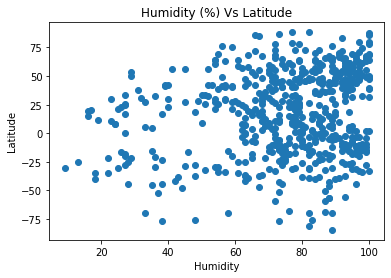

In [38]:
plt.scatter(city_info['humidity'],city_info['lat'])
plt.xlabel('Humidity')
plt.ylabel('Latitude')
plt.title('Humidity (%) Vs Latitude')
plt.show()

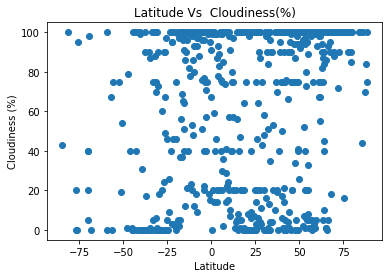

In [39]:
plt.scatter(city_info['lat'],city_info['cloudiness'])
plt.xlabel('Latitude')
plt.ylabel('Cloudiness (%)')
plt.title('Latitude Vs  Cloudiness(%)')
plt.savefig('Latitude Vs Cloudiness(%)',facecolor='white', transparent=False)
plt.show()

Here we plot the latitude values against the precentage of cloudiness. This shows us the how the cloudiness changes depending on the latitude value.

We can see that the closer the latitude value is to 0, the more data points there are closer to cloudiness 100.

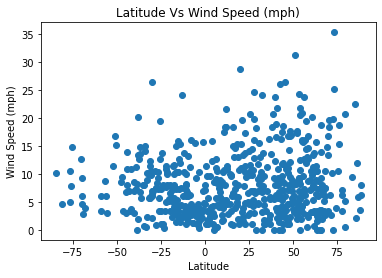

In [40]:
plt.scatter(city_info['lat'],city_info['wind speed'])
plt.xlabel('Latitude')
plt.ylabel('Wind Speed (mph)')
plt.title('Latitude Vs Wind Speed (mph)')
plt.savefig('Latitude Vs Wind Speed (mph)',facecolor='white', transparent=False)
plt.show()

Here we plot the latitude values against the precentage of Wind Speed. This shows us the how the Wind Speed changes depending on the latitude value.

We can see that as the latitude approaches 0, the wind speends also approach 0.

### Linear Regression

In [41]:
# find all countries in northen hempisphere
northern_hemp = city_info[city_info['lat'] >= 0]

# find all countries in southern hempisphere
southern_hemp = city_info[city_info['lat'] < 0]

#### Temperature (F) Vs Latitude


#### Northen Hemisphere

In [42]:
# store x and y values
y_values = northern_hemp['temp'].astype(float)
x_values = northern_hemp['lat'].astype(float)
# y_values
# store linear regression values
slope, intercept, r, p_value, std_error = stats.linregress([x_values],[y_values])

# equation
equation = f'temp = {round(slope,2)} * latitude + {round(intercept,2)}'

# estimated values
lat_values = x_values
est_temp = slope*lat_values + intercept
print(f'The correlation value is {round(r,2)}')

The correlation value is -0.81


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:184: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: invalid value encountered in sqrt
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


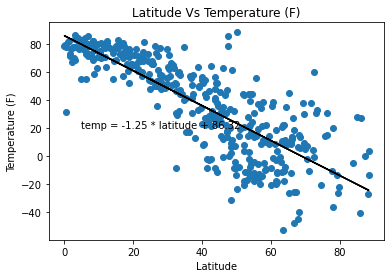

In [43]:
plt.scatter(x_values,y_values)
plt.xlabel('Latitude')
plt.ylabel('Temperature (F)')
plt.title('Latitude Vs Temperature (F)')
plt.annotate(equation,(5,20))
plt.plot(lat_values,est_temp,color = 'black')
plt.savefig('Latitude Vs Temp (Northen)',facecolor='white', transparent=False)
plt.show()

#### Southern Hemipshere

In [44]:
# store x and y values
y_values = southern_hemp['temp'].astype(float)
x_values = southern_hemp['lat'].astype(float)

# store linear regression values
slope, intercept, r, p_value, std_error = stats.linregress(x_values,y_values)

# equation
equation = f'temp = {round(slope,2)} * latitude + {round(intercept,2)}'

# estimated values
lat_values = x_values
est_temp = slope*lat_values + intercept
print(f'The correlation value is {round(r,2)}')

The correlation value is 0.31


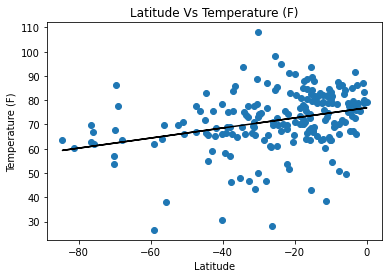

In [45]:
plt.scatter(x_values,y_values)
plt.xlabel('Latitude')
plt.ylabel('Temperature (F)')
plt.title('Latitude Vs Temperature (F)')
plt.annotate(equation,(-45,-20))
plt.plot(lat_values,est_temp,color = 'black')
plt.savefig('Latitude Vs Temp (Southern)',facecolor='white', transparent=False)
plt.show()

We can see that as the latitutde values approach 0. The temperature increases, but the further away the values are from 0, the lower the temperature is. The equator is located at latitutde value = 0. So from the graph we can see that as the you get closer to the equator, the higher the temperature is. The correlation is high for both hemispheres, suggesting that  temperature is related to latitude.

#### Latitude Vs Humidity

#### Northen Hempisphere

In [46]:
# store x and y values
y_values = northern_hemp['lat'].astype(float)
x_values = northern_hemp['humidity'].astype(float)

# store linear regression values
slope, intercept, r, p_value, std_error = stats.linregress(x_values,y_values)

# equation
equation = f'humidity = {round(slope,2)} * latitude + {round(intercept,2)}'

# estimated values
lat_values = x_values
est_hum = slope*lat_values + intercept
print(f'The correlation value is {round(r,2)}')

The correlation value is 0.3


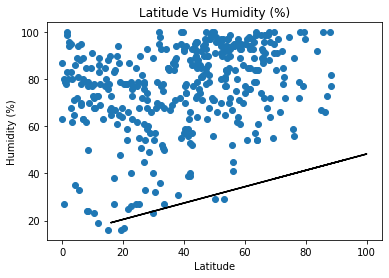

In [47]:
plt.scatter(y_values,x_values)
plt.xlabel('Latitude')
plt.ylabel('Humidity (%)')
plt.title('Latitude Vs Humidity (%)')
plt.annotate(equation,(43,10))
plt.plot(lat_values,est_hum,color = 'black')
plt.savefig('Latitude Vs Humidty (Northern)',facecolor='white', transparent=False)
plt.show()

#### Southern Hempisphere

In [48]:
# store x and y values
x_values = southern_hemp['lat'].astype(float)
y_values = southern_hemp['humidity'].astype(float)

# store linear regression values
slope, intercept, r, p_value, std_error = stats.linregress(x_values,y_values)

# equation
equation = f'humidity = {round(slope,2)} * latitude + {round(intercept,2)}'

# estimated values
lat_values = x_values
est_hum = slope*lat_values + intercept
print(f'The correlation value is {round(r,2)}')

The correlation value is 0.23


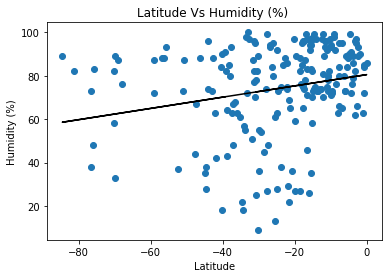

In [49]:
plt.scatter(x_values,y_values)
plt.ylabel('Humidity (%)')
plt.xlabel('Latitude')
plt.title('Latitude Vs Humidity (%) ')
plt.annotate(equation,(10,-65))
plt.plot(lat_values,est_hum,color = 'black')
plt.savefig('Latitude Vs Humidty (Southern)',facecolor='white', transparent=False)
plt.show()

The regression models for latitude vs humidity suggest that the further away from latitude 0, the higher the humidity percentage is. The correlation values are low (-001 and -0.05), so we can say that humidity isnt related to latitude.

We can see that in the northen hemisphere there seems to be more data values with higher humidty percennatge. This could also be because the northern hempishpere has more data points (just because there are more cities in the northern hempisphere, it is more likely that a city is within the northern hemisphere).

#### Latitude Vs Cloudiness

#### Northren Hempisphere

In [50]:
# store x and y values
x_values = northern_hemp['lat'].astype(float)
y_values = northern_hemp['cloudiness'].astype(float)

# store linear regression values
slope, intercept, r, p_value, std_error = stats.linregress(x_values,y_values)

# equation
equation = f'cloudiness = {round(slope,2)} * latitude + {round(intercept,2)}'

# estimated values
lat_values = x_values
est_hum = slope*lat_values + intercept
print(f'The correlation value is {round(r,2)}')

The correlation value is 0.26


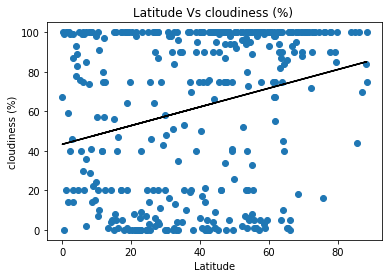

In [51]:
plt.scatter(x_values,y_values)
plt.ylabel('cloudiness (%)')
plt.xlabel('Latitude')
plt.title('Latitude Vs cloudiness (%) ')
plt.annotate(equation,(10,-65))
plt.plot(lat_values,est_hum,color = 'black')
plt.savefig('Latitude Vs cloudiness (Northern)',facecolor='white', transparent=False)
plt.show()


#### Southern Hempisphere

In [52]:
# store x and y values
x_values = southern_hemp['lat'].astype(float)
y_values = southern_hemp['cloudiness'].astype(float)

# store linear regression values
slope, intercept, r, p_value, std_error = stats.linregress(x_values,y_values)

# equation
equation = f'cloudiness = {round(slope,2)} * latitude + {round(intercept,2)}'

# estimated values
lat_values = x_values
est_hum = slope*lat_values + intercept
print(f'The correlation value is {round(r,2)}')

The correlation value is 0.35


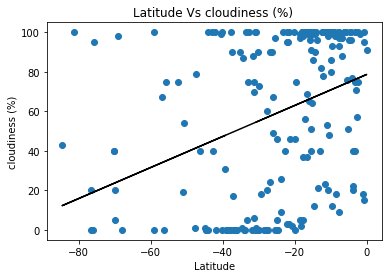

In [53]:
plt.scatter(x_values,y_values)
plt.ylabel('cloudiness (%)')
plt.xlabel('Latitude')
plt.title('Latitude Vs cloudiness (%) ')
plt.annotate(equation,(10,-65))
plt.plot(lat_values,est_hum,color = 'black')
plt.savefig('Latitude Vs cloudiness (Southern)',facecolor='white', transparent=False)
plt.show()

 From the grpah in the that the futher away from latitude 0 we get, the more cloudy it is. the correlation  values are low (0.05 and 0.15), so we can say that cloudiness is not related to latitude. In the northern hemisphere the values appear to have to main bunches.